In [ ]:
!pip install imageio
!pip install -q git+https://github.com/tensorflow/docs
import tensorflow as tf
import matplotlib.pyplot as plt
import glob, imageio, os, PIL, time, pathlib 
import numpy as np
from IPython import display
from tensorflow_docs.vis import embed
 
# Keras Imports
from tensorflow.keras import layers
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import load_model

     |████████████████████████████████| 1.0MB 7.0MB/s 


## TODO: SPLIT this into another file

In [ ]:
# Differentiable Augmentation for Data-Efficient GAN Training
# Shengyu Zhao, Zhijian Liu, Ji Lin, Jun-Yan Zhu, and Song Han
# https://github.com/mit-han-lab/data-efficient-gans/blob/master/DiffAugment_tf.py
# Instructions on how to use at: https://github.com/mit-han-lab/data-efficient-gans#using-diffaugment-for-your-own-training

import tensorflow as tf


def DiffAugment(x, policy='', channels_first=False):
    if policy:
        if channels_first:
            x = tf.transpose(x, [0, 2, 3, 1])
        for p in policy.split(','):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if channels_first:
            x = tf.transpose(x, [0, 3, 1, 2])
    return x

def rand_brightness(x, strength=0.25):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) - 0.5
    x = x + (magnitude * strength)
    return x

def rand_saturation(x, strength = 0.25):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) * 2
    x_mean = tf.reduce_mean(x, axis=3, keepdims=True)
    x = (x - x_mean) * (magnitude * strength) + x_mean
    return x

def rand_contrast(x, strength=0.25):
    magnitude = tf.random.uniform([tf.shape(x)[0], 1, 1, 1]) + 0.5
    x_mean = tf.reduce_mean(x, axis=[1, 2, 3], keepdims=True)
    x = (x - x_mean) * (magnitude * strength) + x_mean
    return x

def rand_translation(x, ratio=0.03):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    shift = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
    translation_x = tf.random.uniform([batch_size, 1], -shift[0], shift[0] + 1, dtype=tf.int32)
    translation_y = tf.random.uniform([batch_size, 1], -shift[1], shift[1] + 1, dtype=tf.int32)
    grid_x = tf.clip_by_value(tf.expand_dims(tf.range(image_size[0], dtype=tf.int32), 0) + translation_x + 1, 0, image_size[0] + 1)
    grid_y = tf.clip_by_value(tf.expand_dims(tf.range(image_size[1], dtype=tf.int32), 0) + translation_y + 1, 0, image_size[1] + 1)
    x = tf.gather_nd(tf.pad(x, [[0, 0], [1, 1], [0, 0], [0, 0]]), tf.expand_dims(grid_x, -1), batch_dims=1)
    x = tf.transpose(tf.gather_nd(tf.pad(tf.transpose(x, [0, 2, 1, 3]), [[0, 0], [1, 1], [0, 0], [0, 0]]), 
                    tf.expand_dims(grid_y, -1), batch_dims=1), [0, 2, 1, 3])
    return x

def rand_cutout(x, ratio=0.1):
    batch_size = tf.shape(x)[0]
    image_size = tf.shape(x)[1:3]
    cutout_size = tf.cast(tf.cast(image_size, tf.float32) * ratio + 0.5, tf.int32)
    offset_x = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[0] + (1 - cutout_size[0] % 2), dtype=tf.int32)
    offset_y = tf.random.uniform([tf.shape(x)[0], 1, 1], maxval=image_size[1] + (1 - cutout_size[1] % 2), dtype=tf.int32)
    grid_batch, grid_x, grid_y = tf.meshgrid(tf.range(batch_size, dtype=tf.int32), tf.range(cutout_size[0], dtype=tf.int32), 
                                            tf.range(cutout_size[1], dtype=tf.int32), indexing='ij')
    cutout_grid = tf.stack([grid_batch, grid_x + offset_x - cutout_size[0] // 2, grid_y + offset_y - cutout_size[1] // 2], axis=-1)
    mask_shape = tf.stack([batch_size, image_size[0], image_size[1]])
    cutout_grid = tf.maximum(cutout_grid, 0)
    cutout_grid = tf.minimum(cutout_grid, tf.reshape(mask_shape - 1, [1, 1, 1, 3]))
    mask = tf.maximum(1 - tf.scatter_nd(cutout_grid, tf.ones([batch_size, cutout_size[0], cutout_size[1]], dtype=tf.float32), mask_shape), 0)
    x = x * tf.expand_dims(mask, axis=3)
    return x

########################### End DiffAugment Augmentation, start additional general Augmentation ###########################

def horizontal_flip(x):
    ''' Horizontal Flip Image Augmentation'''
    x = tf.image.random_flip_left_right(x)
    return x

def crop(x, image_size):
    ''' Random Crop for Image Augmentation'''
    x = tf.image.random_crop(x, size=[image_size,image_size,3])
    return x


AUGMENT_FNS = {
    'horizontal_flip': [horizontal_flip],
    'color': [rand_brightness, rand_saturation, rand_contrast],
    'translation': [rand_translation],
    'cutout': [rand_cutout],
}


## Function Definitions

In [ ]:
# Refresh tensors if something fails
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(
    tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

In [ ]:
batch_size              = 32
total_train_examples    = 30243
steps_per_epoch         = total_train_examples // batch_size
MAPS                    = 128
learning_rate           = 0.0001
# noise vector dim 
noise_dim               = 128
num_examples_to_generate= 32
image_size              = 98
num_channels            = 3
seed                    = tf.random.normal([num_examples_to_generate,
                                            noise_dim])
# Fliter Changer
# It's case sensitive
FRUIT_FILTER    = 'Grape'

# batch size per TPU replica
per_replica_batch_size  = batch_size // strategy.num_replicas_in_sync

In [ ]:
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([100, 100, 3], tf.float32),
}

In [ ]:
def parse_tfrecord(example_proto):
  features = tf.io.parse_example(example_proto, image_feature_description)
  label = features['label']
  image = features['image']
  image = tf.image.resize(image, [image_size, image_size],
                          method=tf.image.ResizeMethod.BICUBIC)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = (image  - 127.5) / 127.5
  return image, label

In [ ]:
def label_filter(ds):
  return ds.filter(lambda x,y: tf.equal(y, FRUIT_FILTER))

In [ ]:
def get_dataset(batch_size, is_training=True, cache=True):
  PATH = 'gs://ai_evaluation/Fruits/tfrecords/train/*.tfrecords'
  dataset = tf.data.Dataset.list_files(PATH)
  dataset = dataset.interleave(tf.data.TFRecordDataset,
                                cycle_length=tf.data.experimental.AUTOTUNE,
                                num_parallel_calls=tf.data.experimental.AUTOTUNE)
  if is_training:
    options = tf.compat.v1.data.Options()
    options.experimental_deterministic = False
    dataset = dataset.with_options(options)
    dataset = dataset.shuffle(total_train_examples)
  
  dataset = dataset.map(parse_tfrecord,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.apply(label_filter)
  dataset = dataset.map(lambda x, y: x,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size,
                          drop_remainder=True)
  
  if is_training:
    dataset = dataset.repeat()
  
  # print(list(dataset.as_numpy_iterator())[0])
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return dataset

In [ ]:
init = RandomNormal(mean=0.0, stddev=0.02)

def create_generator():
    seed = tf.keras.Input(shape=((noise_dim,)))
    x = layers.Flatten()(seed)
    x = layers.Dense(5*5*noise_dim*8, use_bias=False)(x)
    x = layers.Reshape((5, 5, noise_dim*8))(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(noise_dim*4, (5, 5), strides=(2, 2),
                               padding='same', kernel_initializer=init,
                               use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(noise_dim*2, (5, 5), strides=(2, 2),
                               kernel_initializer=init, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(noise_dim, (5, 5), strides=(2, 2),
                               kernel_initializer=init, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2),
                               padding='same', kernel_initializer=init,
                               use_bias=False, activation='tanh')(x)

    model = tf.keras.Model(inputs=seed, outputs=x, name="Generator")    
    return model

In [ ]:
def create_discriminator():
    image = tf.keras.Input(shape=((98,98,3)))
    
    x = layers.Conv2D(noise_dim, (5, 5), strides=(2, 2), padding='same',
                      kernel_initializer=init, use_bias=False)(image)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(noise_dim*2, (5, 5), strides=(2, 2), padding='same',
                      kernel_initializer=init, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(noise_dim*4, (5, 5), strides=(2, 2), padding='same',
                      kernel_initializer=init, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2D(noise_dim*8, (5, 5), strides=(2, 2), padding='same',
                      kernel_initializer=init, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='linear')(x)
    # x2 = layers.Dense(1, activation='linear')(x)
    
    model = tf.keras.Model(inputs=[image], outputs=[x], name="Discriminator")
    return model

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(
    reduction=tf.keras.losses.Reduction.NONE,
    from_logits=True)

def generator_loss(fake_output):
    loss = cross_entropy(tf.ones_like(fake_output), fake_output)
    loss = tf.reduce_sum(loss * (1. / batch_size))
    return loss

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    total_loss = tf.reduce_sum(total_loss * (1. / batch_size))
    return total_loss

with strategy.scope():
  generator_optimizer = tf.keras.optimizers.Adam(3e-4, 
                                                 beta_1=0.0, 
                                                 beta_2=0.999)
  discriminator_optimizer = tf.keras.optimizers.Adam(3e-4,
                                                     beta_1=0.0,
                                                     beta_2=0.999)

## Train Steps

In [ ]:
seed = tf.random.normal([num_examples_to_generate, noise_dim])
# labs = tf.cast(120*tf.random.uniform((32,)),tf.int32)
# Augmentation setting/config
diffaugment_policy = 'horizontal_flip,color,translation,cutout'

In [ ]:
def step_fn(images):
  noise = tf.random.normal([per_replica_batch_size, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)
    real_output = discriminator(DiffAugment(images,
                                policy=diffaugment_policy),
                                training=True)
    fake_output = discriminator(DiffAugment(generated_images,
                                policy=diffaugment_policy),
                                training=True)

    gen_loss = generator_loss(fake_output)

    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss,
                                             generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                                  discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,
                                              discriminator.trainable_variables))

@tf.function
def train_steps(iterator, steps):
  for _ in tf.range(steps):
    strategy.run(step_fn, args=(next(iterator),))

In [ ]:
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(9,9))
  for i in range(predictions.shape[0]):
      plt.subplot(3, 3, i+1)
      plt.imshow(((np.array(predictions[i]) * 127.5) + 127.5).astype(np.uint8))
      plt.axis('off')
      if i == 8:
        break
  # TODO: have diff fruits
  plt.savefig(FRUIT_FILTER+'/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

def print_examples(model):
  example_seed = tf.random.normal([num_examples_to_generate, noise_dim])
  predictions = model(example_seed, training=False)

  fig = plt.figure(figsize=(9,9))
  for i in range(predictions.shape[0]):
      plt.subplot(3, 3, i+1)
      plt.imshow(((np.array(predictions[i]) * 127.5) + 127.5).astype(np.uint8))
      plt.axis('off')
      if i == 8:
        break
  
def display_image(epoch_no):
  return PIL.Image.open(FRUIT_FILTER+'/image_at_epoch_{:04d}.png'.format(epoch_no))

## Training Loop

In [ ]:
def train(dataset, epochs):
  train_iterator = iter(dataset)

  # Make folder for storing the epoch images
  if not os.path.exists(FRUIT_FILTER):
        os.makedirs(FRUIT_FILTER)

  for epoch in range(epochs):
    start = time.time()

    train_steps(train_iterator, tf.convert_to_tensor(steps_per_epoch))

    display.clear_output(wait=True)
    generate_and_save_images(generator,epoch + 1,seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1,
                                                time.time()-start))

  display.clear_output(wait=True)

  # Gracefully stolen from the tensorflow documentation
  anim_file = FRUIT_FILTER+'.gif'
  with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob(FRUIT_FILTER+'/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
      image = imageio.imread(filename)
      writer.append_data(image)
    try:
      image = imageio.imread(filename)
      writer.append_data(image)
    except:
      print("Can't read those images")
  
  # embed.embed_file(anim_file)
  # generate_and_save_images(generator,epochs,seed)

## Training on TPU

In [ ]:
EPOCHS = 50

train_dataset = strategy.distribute_datasets_from_function(
    lambda _: get_dataset(per_replica_batch_size, is_training=True))

### Init the model

In [ ]:
with strategy.scope():
  generator = create_generator()
  discriminator = create_discriminator()
  # print(discriminator.summary())
  # print(generator.summary())

### Train the Model

We also save the model and the gif after that


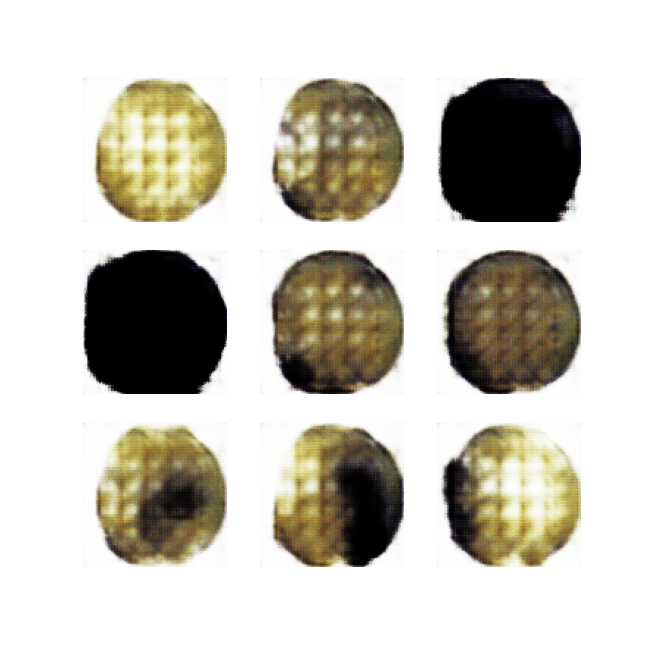

In [ ]:
with strategy.scope():
  train(train_dataset, EPOCHS)
  generator.save(FRUIT_FILTER+"gen.h5")

embed.embed_file(FRUIT_FILTER+'.gif')

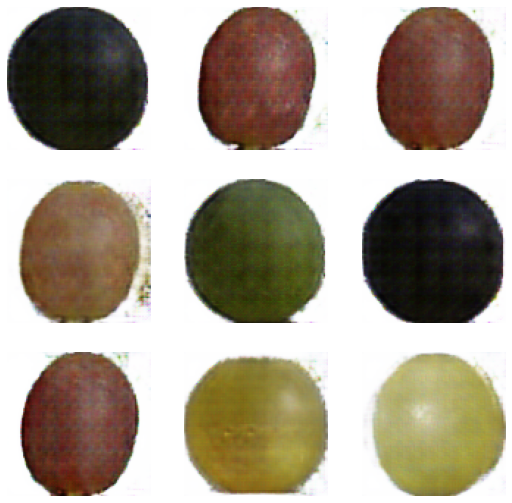

In [ ]:
print_examples(generator)

# Evaluation

Installing some supporting Libraries

In [ ]:
!pip install -q git+https://github.com/tensorflow/docs
!pip install tensorflow-gan
import tensorflow as tf
import matplotlib.pyplot as plt
import glob, imageio, os, PIL, time, pathlib 
import numpy as np
from IPython import display
%matplotlib inline

# Keras Imports
from tensorflow.keras import layers
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import load_model

     |████████████████████████████████| 1.0MB 9.7MB/s 
     |████████████████████████████████| 368kB 11.2MB/s 


In [ ]:
noise_dim               = 128
batch_size              = 32
image_size              = 98
num_channels            = 3
saved_model_location    = './Saved/'

In [ ]:
image_feature_description = {
    'height': tf.io.FixedLenFeature([], tf.int64),
    'width': tf.io.FixedLenFeature([], tf.int64),
    'depth': tf.io.FixedLenFeature([], tf.int64),
    'label': tf.io.FixedLenFeature([], tf.string),
    'image': tf.io.FixedLenFeature([100, 100, 3], tf.float32),
}

In [ ]:
def parse_tfrecord(example_proto):
  features = tf.io.parse_example(example_proto, image_feature_description)
  label = features['label']
  image = features['image']
  image = tf.image.resize(image, [image_size, image_size],
                          method=tf.image.ResizeMethod.BICUBIC)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = (image  - 127.5) / 127.5
  return image, label

In [ ]:
def label_filter(ds):
  return ds.filter(lambda x,y: tf.equal(y, FRUIT_FILTER))
def image_fixer(image):
  return ((np.array(image) * 127.5) + 127.5).astype(np.uint8)

In [ ]:
def get_dataset(batch_size, is_training=True, cache=True):
  PATH = 'gs://ai_evaluation/Fruits/tfrecords/train/*.tfrecords'
  dataset = tf.data.Dataset.list_files(PATH)
  dataset = dataset.interleave(tf.data.TFRecordDataset,
                                cycle_length=tf.data.experimental.AUTOTUNE,
                                num_parallel_calls=tf.data.experimental.AUTOTUNE)
  if is_training:
    options = tf.compat.v1.data.Options()
    options.experimental_deterministic = False
    dataset = dataset.with_options(options)
    dataset = dataset.shuffle(total_train_examples)
  
  dataset = dataset.map(parse_tfrecord,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.apply(label_filter)
  dataset = dataset.map(lambda x, y: x,
                        num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size,
                          drop_remainder=True)
  
  if is_training:
    dataset = dataset.repeat()
  
  # print(list(dataset.as_numpy_iterator())[0])
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

  return dataset

In [ ]:
FRUIT_FILTER      = 'Grape'
try:
  tf.keras.backend.clear_session()
  tf.compat.v1.reset_default_graph()
  tf.compat.v1.enable_eager_execution()
  tf.executing_eagerly()
except:
  raise RuntimeError("Don't have non-eager execution available, Restart the runtme")

Applegen.h5  Bananagen.h5  Grapegen.h5	Tomatogen.h5


In [ ]:
# real_images = get_dataset(batch_size, is_training=False)
FRUIT_FILTER = 'Tomato'
generator = load_model(saved_model_location+FRUIT_FILTER+'gen.h5', compile=False)

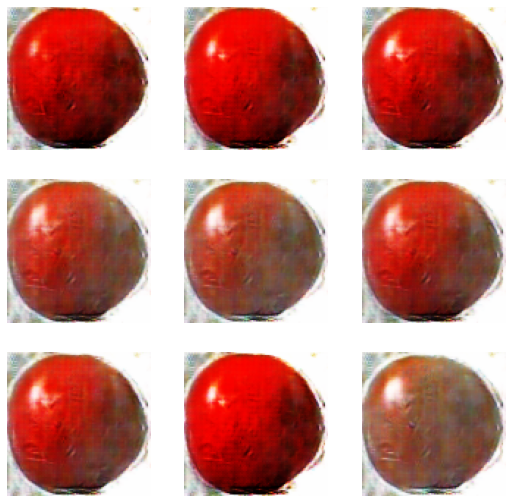

In [ ]:
num_examples_to_generate = 9
print_examples(generator)

In [ ]:
just_images_array = []

for stuff in real_images.take(15):
  just_images_array.extend(image_fixer(stuff.numpy()))

just_images_array = np.array(just_images_array)
print(just_images_array.shape)

(480, 98, 98, 3)


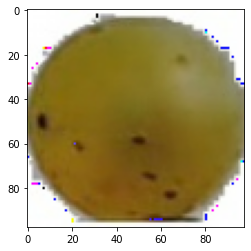

In [ ]:
# Sanity Check 1
plt.imshow(just_images_array[0])

In [ ]:
predictions_array = []
for iterations in range(15):
  custom_seed = tf.random.normal([batch_size, noise_dim])
  predictions = generator(custom_seed, training=False).numpy()
  predictions_array.extend(image_fixer(predictions))

predictions_array = np.array(predictions_array)
print(predictions_array.shape)

(480, 98, 98, 3)


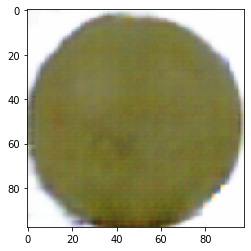

In [ ]:
# Sanity Check 2
plt.imshow(predictions_array[0])

### Inception Score and Calculation

In [ ]:
'''
From https://github.com/tsc2017/Inception-Score
Code derived from https://github.com/openai/improved-gan/blob/master/inception_score/model.py and https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/eval/python/classifier_metrics_impl.py

Usage:
    Call get_inception_score(images, splits=10)
Args:
    images: A numpy array with values ranging from 0 to 255 and shape in the form [N, 3, HEIGHT, WIDTH] where N, HEIGHT and WIDTH can be arbitrary. A dtype of np.uint8 is recommended to save CPU memory.
    splits: The number of splits of the images, default is 10.
Returns:
    Mean and standard deviation of the Inception Score across the splits.
'''

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import os
import functools
import numpy as np
import time
from tensorflow.python.ops import array_ops
# pip install tensorflow-gan
import tensorflow_gan as tfgan
session=tf.compat.v1.InteractiveSession()
# A smaller BATCH_SIZE reduces GPU memory usage, but at the cost of a slight slowdown
BATCH_SIZE = 50
INCEPTION_TFHUB = 'https://tfhub.dev/tensorflow/tfgan/eval/inception/1'
INCEPTION_OUTPUT = 'logits'

# Run images through Inception.
inception_images = tf.compat.v1.placeholder(tf.float32, [None, 3, None, None], name = 'inception_images')
def inception_logits(images = inception_images, num_splits = 1):
    images = tf.transpose(images, [0, 2, 3, 1])
    size = 299
    images = tf.compat.v1.image.resize_bilinear(images, [size, size])
    generated_images_list = array_ops.split(images, num_or_size_splits = num_splits)
    logits = tf.map_fn(
        fn = tfgan.eval.classifier_fn_from_tfhub(INCEPTION_TFHUB, INCEPTION_OUTPUT, True),
        elems = array_ops.stack(generated_images_list),
        parallel_iterations = 8,
        back_prop = False,
        swap_memory = True,
        name = 'RunClassifier')
    logits = array_ops.concat(array_ops.unstack(logits), 0)
    return logits

logits=inception_logits()

def get_inception_probs(inps):
    session=tf.get_default_session()
    n_batches = int(np.ceil(float(inps.shape[0]) / BATCH_SIZE))
    preds = np.zeros([inps.shape[0], 1000], dtype = np.float32)
    for i in range(n_batches):
        inp = inps[i * BATCH_SIZE:(i + 1) * BATCH_SIZE] / 255. * 2 - 1
        preds[i * BATCH_SIZE : i * BATCH_SIZE + min(BATCH_SIZE, inp.shape[0])] = session.run(logits,{inception_images: inp})[:, :1000]
    preds = np.exp(preds) / np.sum(np.exp(preds), 1, keepdims=True)
    return preds

def preds2score(preds, splits=1):
    scores = []
    for i in range(splits):
        part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
        kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
        kl = np.mean(np.sum(kl, 1))
        scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)

def get_inception_score(images, splits=1):
    assert(type(images) == np.ndarray)
    assert(len(images.shape) == 4)
    assert(images.shape[1] == 3)
    assert(np.min(images[0]) >= 0 and np.max(images[0]) > 10), 'Image values should be in the range [0, 255]'
    print('Calculating Inception Score with %i images in %i splits' % (images.shape[0], splits))
    start_time=time.time()
    preds = get_inception_probs(images)
    mean, std = preds2score(preds, splits)
    print('Inception Score calculation time: %f s' % (time.time() - start_time))
    return mean, std  # Reference values: 11.38 for 50000 CIFAR-10 training set images, or mean=11.31, std=0.10 if in 10 splits.

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:329: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


### Frechet Inception Distance and Calculation

In [ ]:
'''
From https://github.com/tsc2017/Frechet-Inception-Distance
Code derived from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/gan/python/eval/python/classifier_metrics_impl.py

Usage:
    Call get_fid(images1, images2)
Args:
    images1, images2: Numpy arrays with values ranging from 0 to 255 and shape in the form [N, 3, HEIGHT, WIDTH] where N, HEIGHT and WIDTH can be arbitrary. 
    dtype of the images is recommended to be np.uint8 to save CPU memory.
Returns:
    Frechet Inception Distance between the two image distributions.
'''

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import os
import functools
import numpy as np
import time
from tensorflow.python.ops import array_ops
# pip install tensorflow-gan
import tensorflow_gan as tfgan

session=tf.compat.v1.InteractiveSession()
# A smaller BATCH_SIZE reduces GPU memory usage, but at the cost of a slight slowdown
BATCH_SIZE = 50

# Run images through Inception.
inception_images = tf.compat.v1.placeholder(tf.float32, [None, 3, None, None], name = 'inception_images')
activations1 = tf.compat.v1.placeholder(tf.float32, [None, None], name = 'activations1')
activations2 = tf.compat.v1.placeholder(tf.float32, [None, None], name = 'activations2')
fcd = tfgan.eval.frechet_classifier_distance_from_activations(activations1, activations2)

INCEPTION_TFHUB = 'https://tfhub.dev/tensorflow/tfgan/eval/inception/1'
INCEPTION_FINAL_POOL = 'pool_3'

def inception_activations(images = inception_images, num_splits = 1):
    images = tf.transpose(images, [0, 2, 3, 1])
    size = 299
    images = tf.compat.v1.image.resize_bilinear(images, [size, size])
    generated_images_list = array_ops.split(images, num_or_size_splits = num_splits)
    activations = tf.map_fn(
        fn = tfgan.eval.classifier_fn_from_tfhub(INCEPTION_TFHUB, INCEPTION_FINAL_POOL, True),
        elems = array_ops.stack(generated_images_list),
        parallel_iterations = 1,
        back_prop = False,
        swap_memory = True,
        name = 'RunClassifier')
    activations = array_ops.concat(array_ops.unstack(activations), 0)
    return activations

activations =inception_activations()

def get_inception_activations(inps):
    n_batches = int(np.ceil(float(inps.shape[0]) / BATCH_SIZE))
    act = np.zeros([inps.shape[0], 2048], dtype = np.float32)
    for i in range(n_batches):
        inp = inps[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] / 255. * 2 - 1
        act[i * BATCH_SIZE : i * BATCH_SIZE + min(BATCH_SIZE, inp.shape[0])] = session.run(activations, feed_dict = {inception_images: inp})
    return act

def activations2distance(act1, act2):
    return session.run(fcd, feed_dict = {activations1: act1, activations2: act2})
        
def get_fid(images1, images2):
    session=tf.get_default_session()
    assert(type(images1) == np.ndarray)
    assert(len(images1.shape) == 4)
    assert(images1.shape[1] == 3)
    assert(np.min(images1[0]) >= 0 and np.max(images1[0]) > 10), 'Image values should be in the range [0, 255]'
    assert(type(images2) == np.ndarray)
    assert(len(images2.shape) == 4)
    assert(images2.shape[1] == 3)
    assert(np.min(images2[0]) >= 0 and np.max(images2[0]) > 10), 'Image values should be in the range [0, 255]'
    assert(images1.shape == images2.shape), 'The two numpy arrays must have the same shape'
    print('Calculating FID with %i images from each distribution' % (images1.shape[0]))
    start_time = time.time()
    act1 = get_inception_activations(images1)
    act2 = get_inception_activations(images2)
    fid = activations2distance(act1, act2)
    print('FID calculation time: %f s' % (time.time() - start_time))
    return fid

/usr/local/lib/python3.7/dist-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:329: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


### Calling and Calculating the metrics

In [ ]:
get_inception_score(predictions_array.transpose([0,3,1,2]),3)

Calculating Inception Score with 480 images in 3 splits
Inception Score calculation time: 5.377608 s


(3.0012028, 0.07864229)

In [ ]:
session.close()

In [ ]:
get_fid(just_images_array.transpose([0,3,1,2]), predictions_array.transpose([0,3,1,2]))

Calculating FID with 480 images from each distribution
FID calculation time: 17.896205 s


250.92561

## Drawing Pictures of the Model Architectures

In [ ]:
!pip install visualkeras
import visualkeras
from PIL import ImageFont

font = ImageFont.truetype("Roboto-Medium.ttf", 16)

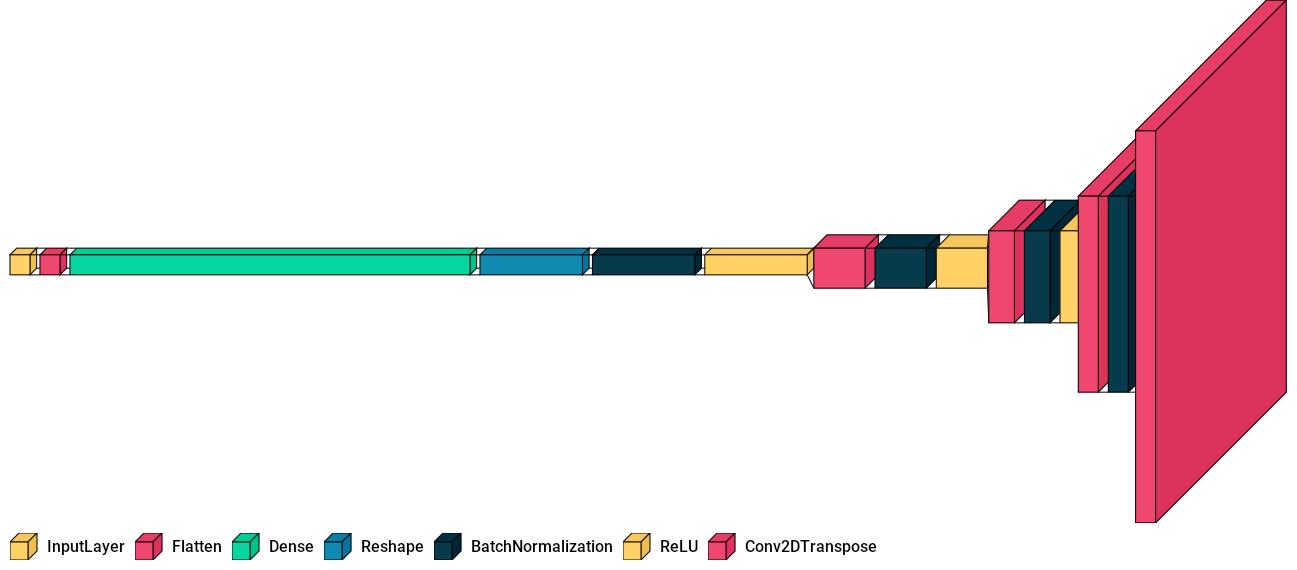

In [ ]:
visualkeras.layered_view(create_generator(), legend=True, font=font)

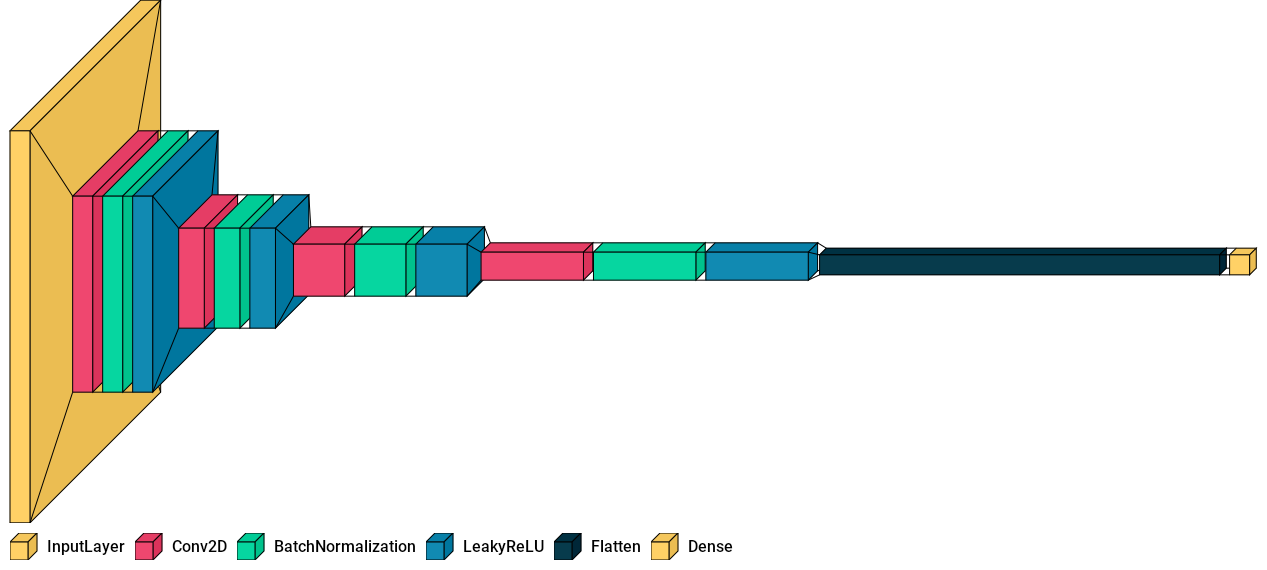

In [ ]:
visualkeras.layered_view(create_discriminator(), legend=True, font=font)